<a href="https://colab.research.google.com/github/roulupen/EVAAssignments/blob/master/Assignment11/Assignment_11_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Assignment 11:
1. Cutout added
2. Using LR Finder to find the best starting learning rate.
3. Using SDG with Momentum.
4. Training for 100 epochs
5. Verbose = 0 (no logs) in the final model run.
6. Saving the top accuracy
7. Showing Training and Test Accuracy curves
8. Runing  GradCAM on the any 25 misclassified images. 

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
import keras.models
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('../content/drive/', force_remount=True)

Mounted at ../content/drive/


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [4]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


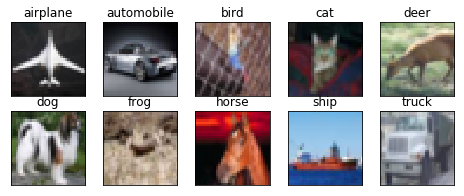

In [5]:
class_names = ['airplane','automobile','bird','cat','deer', 'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [9]:
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()


print('Statistics train=%.3f (%.3f), test=%.3f (%.3f)' % (trainX.mean(), trainX.std(), testX.mean(), testX.std()))

# create generator that centers pixel values
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate the mean on the training dataset
datagen.fit(trainX)
#print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))

# demonstrate effect on a single batch of samples
iterator = datagen.flow(trainX, trainy, batch_size=128)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

# demonstrate effect on entire training dataset
iterator = datagen.flow(trainX, trainy, batch_size=len(trainX), shuffle=False)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

Statistics train=120.708 (64.150), test=121.529 (64.061)
(128, 32, 32, 3) 0.01989002 1.0052702
(50000, 32, 32, 3) -1.6605131e-06 1.0000001


In [0]:
iterator1 = datagen.flow(testX, testy, batch_size=len(testX), shuffle=False)
batch_testX, batch_testy = iterator1.next()

X_train = batchX
X_test = batch_testX

y_train=batchy
y_test=batch_testy
                        

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

### Learning Rate finder class

In [0]:
from matplotlib import pyplot as plt
import math
from keras.callbacks import LambdaCallback
import keras.backend as K


class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if math.isnan(loss) or loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        num_batches = epochs * x_train.shape[0] / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                        batch_size=batch_size, epochs=epochs,
                        callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
            if steps_per_epoch is None:
                try:
                    steps_per_epoch = len(generator)
                except (ValueError, NotImplementedError) as e:
                    raise e('`steps_per_epoch=None` is only valid for a'
                            ' generator based on the '
                            '`keras.utils.Sequence`'
                            ' class. Please specify `steps_per_epoch` '
                            'or use the `keras.utils.Sequence` class.')
            self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(steps_per_epoch))

            # Save weights into a file
            self.model.save_weights('tmp.h5')

            # Remember the original learning rate
            original_lr = K.get_value(self.model.optimizer.lr)

            # Set the initial learning rate
            K.set_value(self.model.optimizer.lr, start_lr)

            callback = LambdaCallback(on_batch_end=lambda batch,
                                      logs: self.on_batch_end(batch, logs))

            self.model.fit_generator(generator=generator,
                                     epochs=epochs,
                                     steps_per_epoch=steps_per_epoch,
                                     callbacks=[callback],
                                     **kw_fit)

            # Restore the weights to the state before model fitting
            self.model.load_weights('tmp.h5')

            # Restore the original learning rate
            K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale('log')

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivative = (self.losses[i] - self.losses[i - sma]) / sma
            derivatives.append(derivative)

        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], derivatives[n_skip_beginning:-n_skip_end])
        plt.xscale('log')
        plt.ylim(y_lim)

### Random cutout logic

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [14]:
# Define the model
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Convolution2D(32, 1, 1))


model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Convolution2D(32, 1, 1))


model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same', name="Grad_CAM"))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Convolution2D(10, 1, 1))

model.add(AveragePooling2D(pool_size = (4,4)))
model.add(Flatten())
model.add(Activation('softmax'))


W0719 08:43:38.914800 140423590455168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  
W0719 08:43:38.932575 140423590455168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0719 08:43:38.935365 140423590455168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0719 08:43:38.966692 140423590455168 deprecation_wrapper.py

In [15]:
from keras.optimizers import SGD
opt = SGD(lr=1e-6, momentum=0.9)

# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

W0719 08:43:40.305750 140423590455168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
__________

### Finding the optimum learning rate for the model with batch size - 128

W0719 08:43:40.900722 140423590455168 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
351/391 [=========================>....] - ETA: 1s - loss: 2.2943 - acc: 0.2573

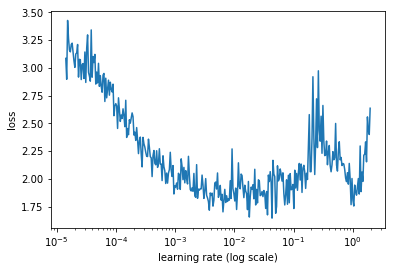

In [16]:
from keras.preprocessing.image import ImageDataGenerator

lr_finder = LRFinder(model)
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))
lr_finder.find_generator(datagen.flow(X_train, Y_train, batch_size = 128), start_lr=1e-5, end_lr=10, epochs=50, steps_per_epoch=None)
#lr_finder.find(train_features, train_labels, start_lr=1e-5, end_lr=10, batch_size=64, epochs=50)
lr_finder.plot_loss()

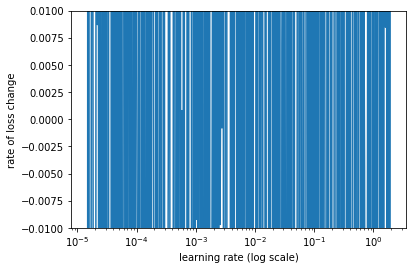

In [17]:
lr_finder.plot_loss_change()

So, from the above graph it looks like the 1e-2 is the optimum learning rate for the model with batch size-128

### Defining the same mode again to reset all the parameters

In [18]:
# Define the model
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Convolution2D(32, 1, 1))


model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Convolution2D(32, 1, 1))


model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same', name="Grad_CAM"))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Convolution2D(10, 1, 1))

model.add(AveragePooling2D(pool_size = (4,4)))
model.add(Flatten())
model.add(Activation('softmax'))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg

### Compiling model with optimum Learning Rate using SGD optimizer with momentum

In [19]:
from keras.optimizers import SGD
opt = SGD(lr=1e-2, momentum=0.9)

# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
__________

### While runing the model I'm running with otimum LR and also defined ReduceLROnPlateau (with patience = 7). So, overally we will get faster learning and when there it more increase in validation accuracy for more than 7 epochs then reducing the Learning Rate.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=100)`


Epoch 1/100
390/390 [==============================] - 13s 33ms/step - loss: 1.5406 - acc: 0.4593 - val_loss: 1.1660 - val_acc: 0.5979

Epoch 00001: val_acc improved from -inf to 0.59790, saving model to ../content/drive/My Drive/EVA/model_after.h5
Epoch 2/100
390/390 [==============================] - 12s 30ms/step - loss: 1.1783 - acc: 0.5925 - val_loss: 1.0841 - val_acc: 0.6340

Epoch 00002: val_acc improved from 0.59790 to 0.63400, saving model to ../content/drive/My Drive/EVA/model_after.h5
Epoch 3/100
390/390 [==============================] - 12s 30ms/step - loss: 1.0384 - acc: 0.6440 - val_loss: 0.9477 - val_acc: 0.6824

Epoch 00003: val_acc improved from 0.63400 to 0.68240, saving model to ../content/drive/My Drive/EVA/model_after.h5
Epoch 4/100
390/390 [==============================] - 12s 30ms/step - loss: 0.9462 - acc: 0.6793 - val_loss: 0.8437 - val_acc: 0.7233

Epoch 00004: val_acc improved from 0.68240 to 0.72330, saving model to ../content/drive/My Drive/EVA/model_afte

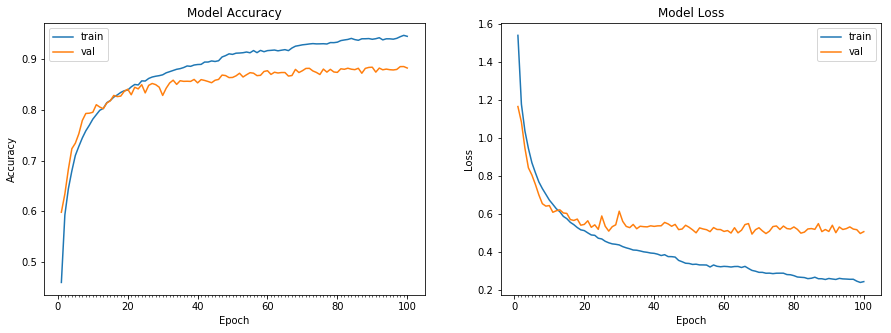

Accuracy on test data is: 88.26


In [20]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

checkpointer = ModelCheckpoint(filepath='../content/drive/My Drive/EVA/model_after.h5', monitor='val_acc', mode='auto', verbose = 1, save_best_only=True)
lr_reducer = ReduceLROnPlateau(monitor='val_acc',factor=0.8, cooldown=0, patience=7, min_lr=0.5e-9,verbose = 1)

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(X_train, Y_train, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (X_test, Y_test), callbacks=[checkpointer, lr_reducer],verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model))

### Loading the highest validation acurracy model and printing the validation accuracy score

In [24]:
model=keras.models.load_model('../content/drive/My Drive/EVA/model_after.h5')
score = model.evaluate(X_test, Y_test, batch_size=128)
print (score[1])


10000/10000 [==============================] - 1s 132us/step
0.8855


### Finding mis-classified image indexes

In [22]:
# getting predictions on val set.
pred = model.predict(X_test)
pred_digits = np.argmax(pred, axis=1)


# now finding some misclassified indexes'.
i=0
mis_class=[]
for i in range(len(Y_test)):
    if( np.argmax(Y_test[i])!= pred_digits[i] ):
        mis_class.append(i)
    if(len(mis_class)==25):
        break

print(mis_class)

[7, 32, 35, 37, 42, 52, 57, 58, 61, 78, 81, 85, 91, 100, 101, 118, 128, 147, 158, 165, 171, 178, 188, 190, 224]


### Genrating Grad-CAM for mis-classified images

Predicted class horse actual class frog


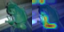

Predicted class horse actual class deer


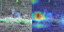

Predicted class horse actual class bird


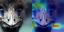

Predicted class horse actual class automobile


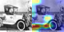

Predicted class horse actual class dog


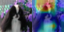

Predicted class airplane actual class airplane


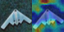

Predicted class airplane actual class horse


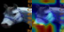

Predicted class truck actual class deer


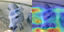

Predicted class horse actual class cat


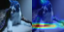

Predicted class bird actual class cat


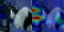

Predicted class automobile actual class automobile


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


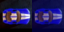

Predicted class deer actual class dog


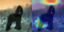

Predicted class bird actual class cat


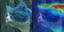

Predicted class horse actual class deer


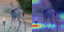

Predicted class horse actual class dog


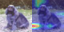

Predicted class horse actual class bird


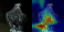

Predicted class horse actual class dog


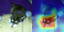

Predicted class horse actual class bird


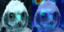

Predicted class horse actual class dog


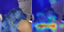

Predicted class truck actual class deer


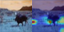

Predicted class truck actual class truck


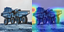

Predicted class truck actual class dog


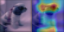

Predicted class truck actual class deer


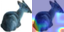

Predicted class truck actual class dog


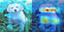

Predicted class horse actual class cat


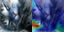

In [23]:
import cv2
from google.colab.patches import cv2_imshow

#images = [100,101,201,510,600,1000,1600,1601,3000,4000,5500,7000,7500,8000,9000,9999]
images = mis_class
for j in images:
  x = testX[j]
  x = np.expand_dims(x, axis=0)
  preds = model.predict(x,batch_size=1)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  print("Predicted class {0} actual class {1}".format(class_names[np.argmax(preds)], class_names[np.argmax(Y_test[j])]))
  last_conv_layer = model.get_layer("Grad_CAM")

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap) 
  img = (testX[j])
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  concatimg = cv2.hconcat([img,superimposed_img])
  cv2_imshow(concatimg)
  cv2.waitKey(0)


**** In the misclassified images some of the misclassified is predicting as correct. I'm not sure where I'm making the mistake. I'll verify it. 